importing libraries (prep)

In [1]:
import numpy as np
import sep

plot of f105w

In [2]:
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import rcParams

%matplotlib inline

rcParams['figure.figsize'] = [10.,8.]

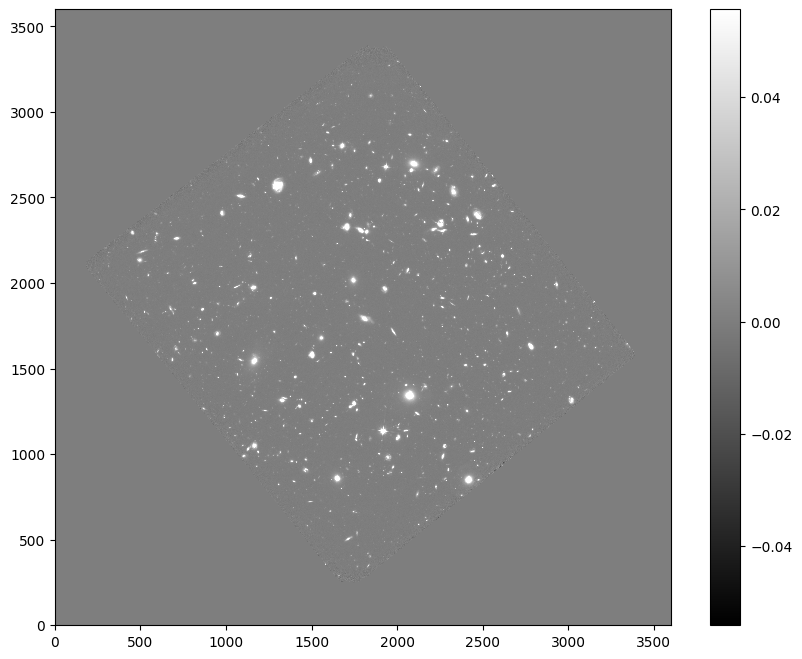

In [3]:
data = fits.getdata("image2.fits")
m, s = np.mean(data), np.std(data)
plt.imshow(data,interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar();
plt.savefig("105woriginal.png")

measure a spacially varying background on the image

In [4]:
data = data.byteswap().newbyteorder()
bkg = sep.Background(data)

evaluate background as 2-d array, same size asoriginal image then show the background

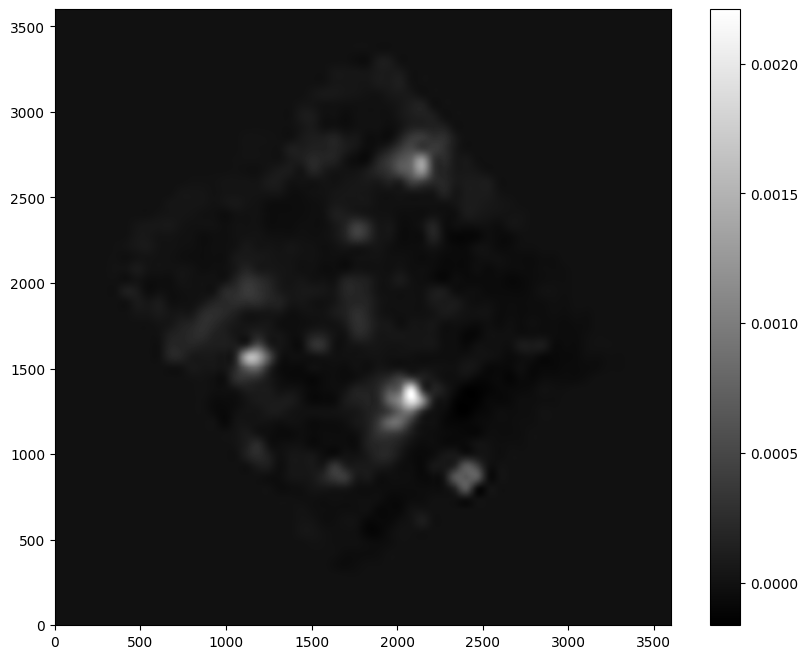

In [5]:
bkg_image = bkg.back()
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();
plt.savefig("105wSepBack.png")

evaluate the background noise as 2-d array, same size as original image show the background noise

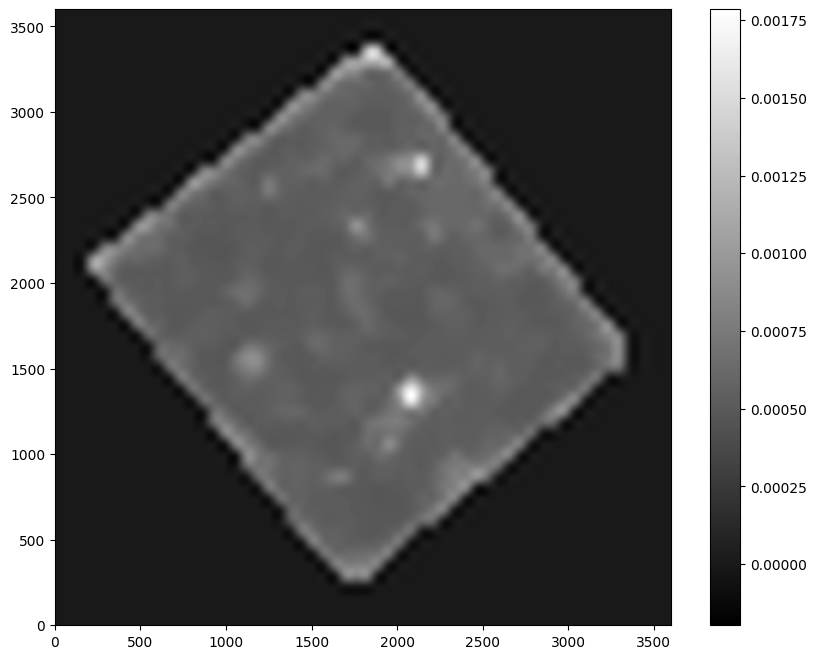

In [6]:
bkg_rms = bkg.rms()
plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();
plt.savefig("bgNoise105w.png")

subtract the background

In [7]:
data_sub = data - bkg

object detection

In [8]:
objects = sep.extract(data_sub, 1.5, err=bkg.globalrms)
len(objects)

8640

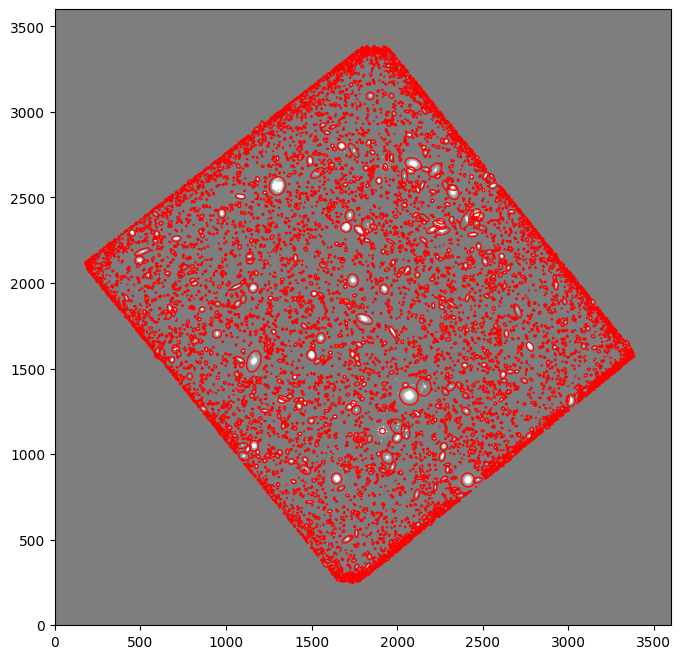

In [9]:
from matplotlib.patches import Ellipse

# plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)

performing simple circular aperture photometry

In [10]:
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'],
                                     3.0, err=bkg.globalrms, gain=1.0)

In [11]:
for i in range(10):
    print("object {:d}: flux = {:f} +/- {:f}".format(i, flux[i], fluxerr[i]))

object 0: flux = 0.031282 +/- 0.176890
object 1: flux = 0.031018 +/- 0.176142
object 2: flux = -0.024388 +/- 0.002883
object 3: flux = 0.001947 +/- 0.044219
object 4: flux = 0.012457 +/- 0.111649
object 5: flux = -0.011228 +/- 0.002875
object 6: flux = 0.029368 +/- 0.171394
object 7: flux = -0.009126 +/- 0.002875
object 8: flux = 0.048023 +/- 0.219161
object 9: flux = 0.027840 +/- 0.166877


plotting histogram for flux

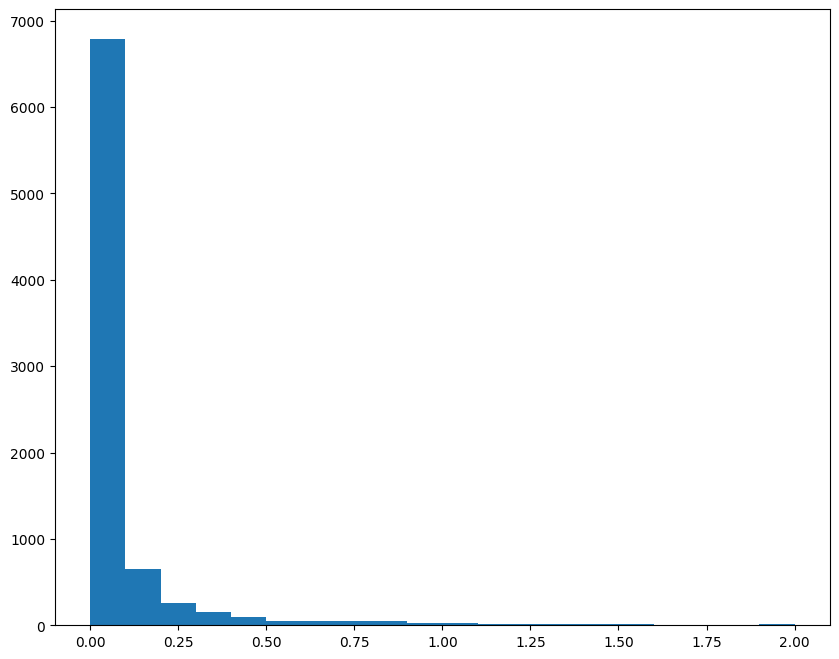

In [12]:
plt.hist(flux, bins=20, range=(0, 2.0))
plt.show()

Print statements for mean, median, std deviation, largest outlier and distance

In [13]:
print(f'median = {np.median(flux)}')
print(f'mean = {np.mean(flux)}')
print(f'standard deviation = {np.std(flux)}')
print(f'largest outlier = {max(flux)}')
print(f'it is {((max(flux)-np.mean(flux))/np.std(flux))} away from the mean')

median = 0.030960064365426664
mean = 0.36185728037707154
standard deviation = 9.243528029706706
largest outlier = 807.2972835731507
it is 87.29734184820526 away from the mean


for rescaling the image data

In [14]:
def rescale_image(data):
    pdata_tmp = data.copy()
    m = np.nanmean(pdata_tmp)
    vplmin = m/2.
    vpmin = np.log10(vplmin)
    vpmax = np.log10(m * 100.)
    pdata_tmp[pdata_tmp<vplmin] = vplmin
    pdata_tmp = np.log10(pdata_tmp)
    return pdata_tmp, vpmin, vpmax

In [15]:
def fits_quicklook(data, fnx=10, fny=10):
    f = plt.figure(figsize=(fnx,fny))
    pdata_tmp, vpmin, vpmax = rescale_image(data)
    plt.imshow(pdata_tmp, vmin=vpmin, vmax=vpmax)

3 color image data initialization

In [16]:
fdata_f160w = "f160w.fits"
fdata_f125w = "f125w.fits"
fdata_f105w = "image2.fits"

hdu_2 = fits.open(fdata_f160w)
hdu_3 = fits.open(fdata_f125w)
hdu_4 = fits.open(fdata_f105w)

data_2 = hdu_2[0].data
data_3 = hdu_3[0].data
data_4 = hdu_4[0].data

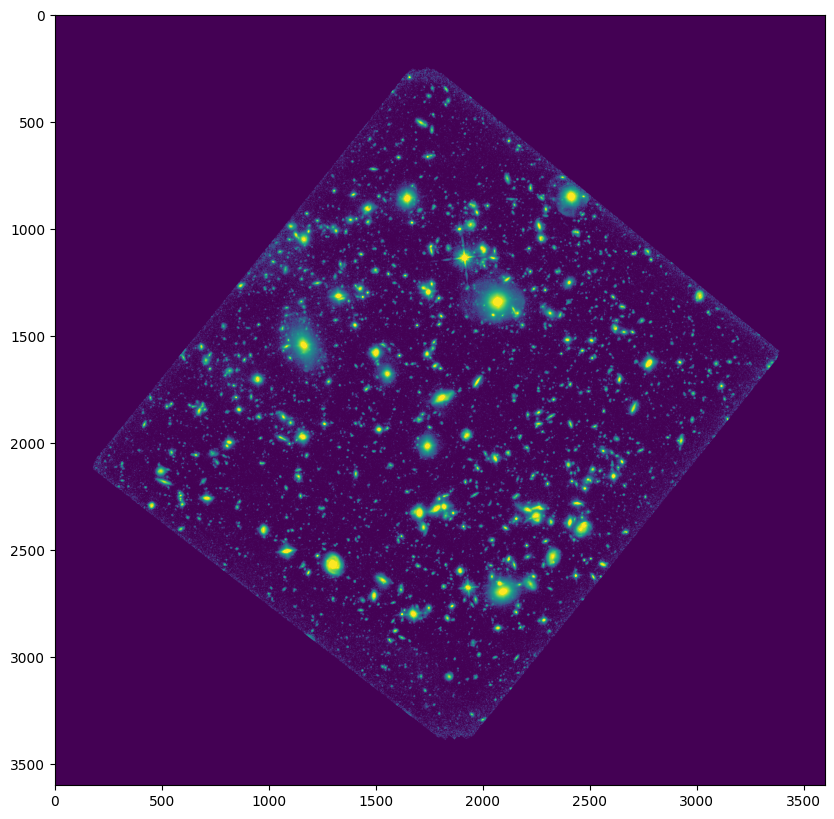

In [17]:
fits_quicklook(data_2)

In [18]:
data_2_res, d2min, d2max = rescale_image(data_2)
data_3_res, d3min, d3max = rescale_image(data_3)
data_4_res, d4min, d4max = rescale_image(data_4)

Limit data to be between the min and max values in the rescaling

In [19]:
data_2_res[data_2_res<d2min] = d2min
data_2_res[data_2_res>d2max] = d2max
data_3_res[data_3_res<d3min] = d3min
data_3_res[data_3_res>d3max] = d3max
data_4_res[data_4_res<d4min] = d4min
data_4_res[data_4_res>d4max] = d4max

create an rgb image that is nx x ny x 3 in size, where each image is either R,G,B

In [20]:
rgb = np.zeros((data_2_res.shape[0], data_2_res.shape[1], 3))
rgb[:,:,0] = (data_2_res-d2min)/(d2max-d2min)
rgb[:,:,1] = (data_3_res-d3min)/(d3max-d3min)
rgb[:,:,2] = (data_4_res-d4min)/(d4max-d4min)

Plot the RGB image and save to a PNG

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


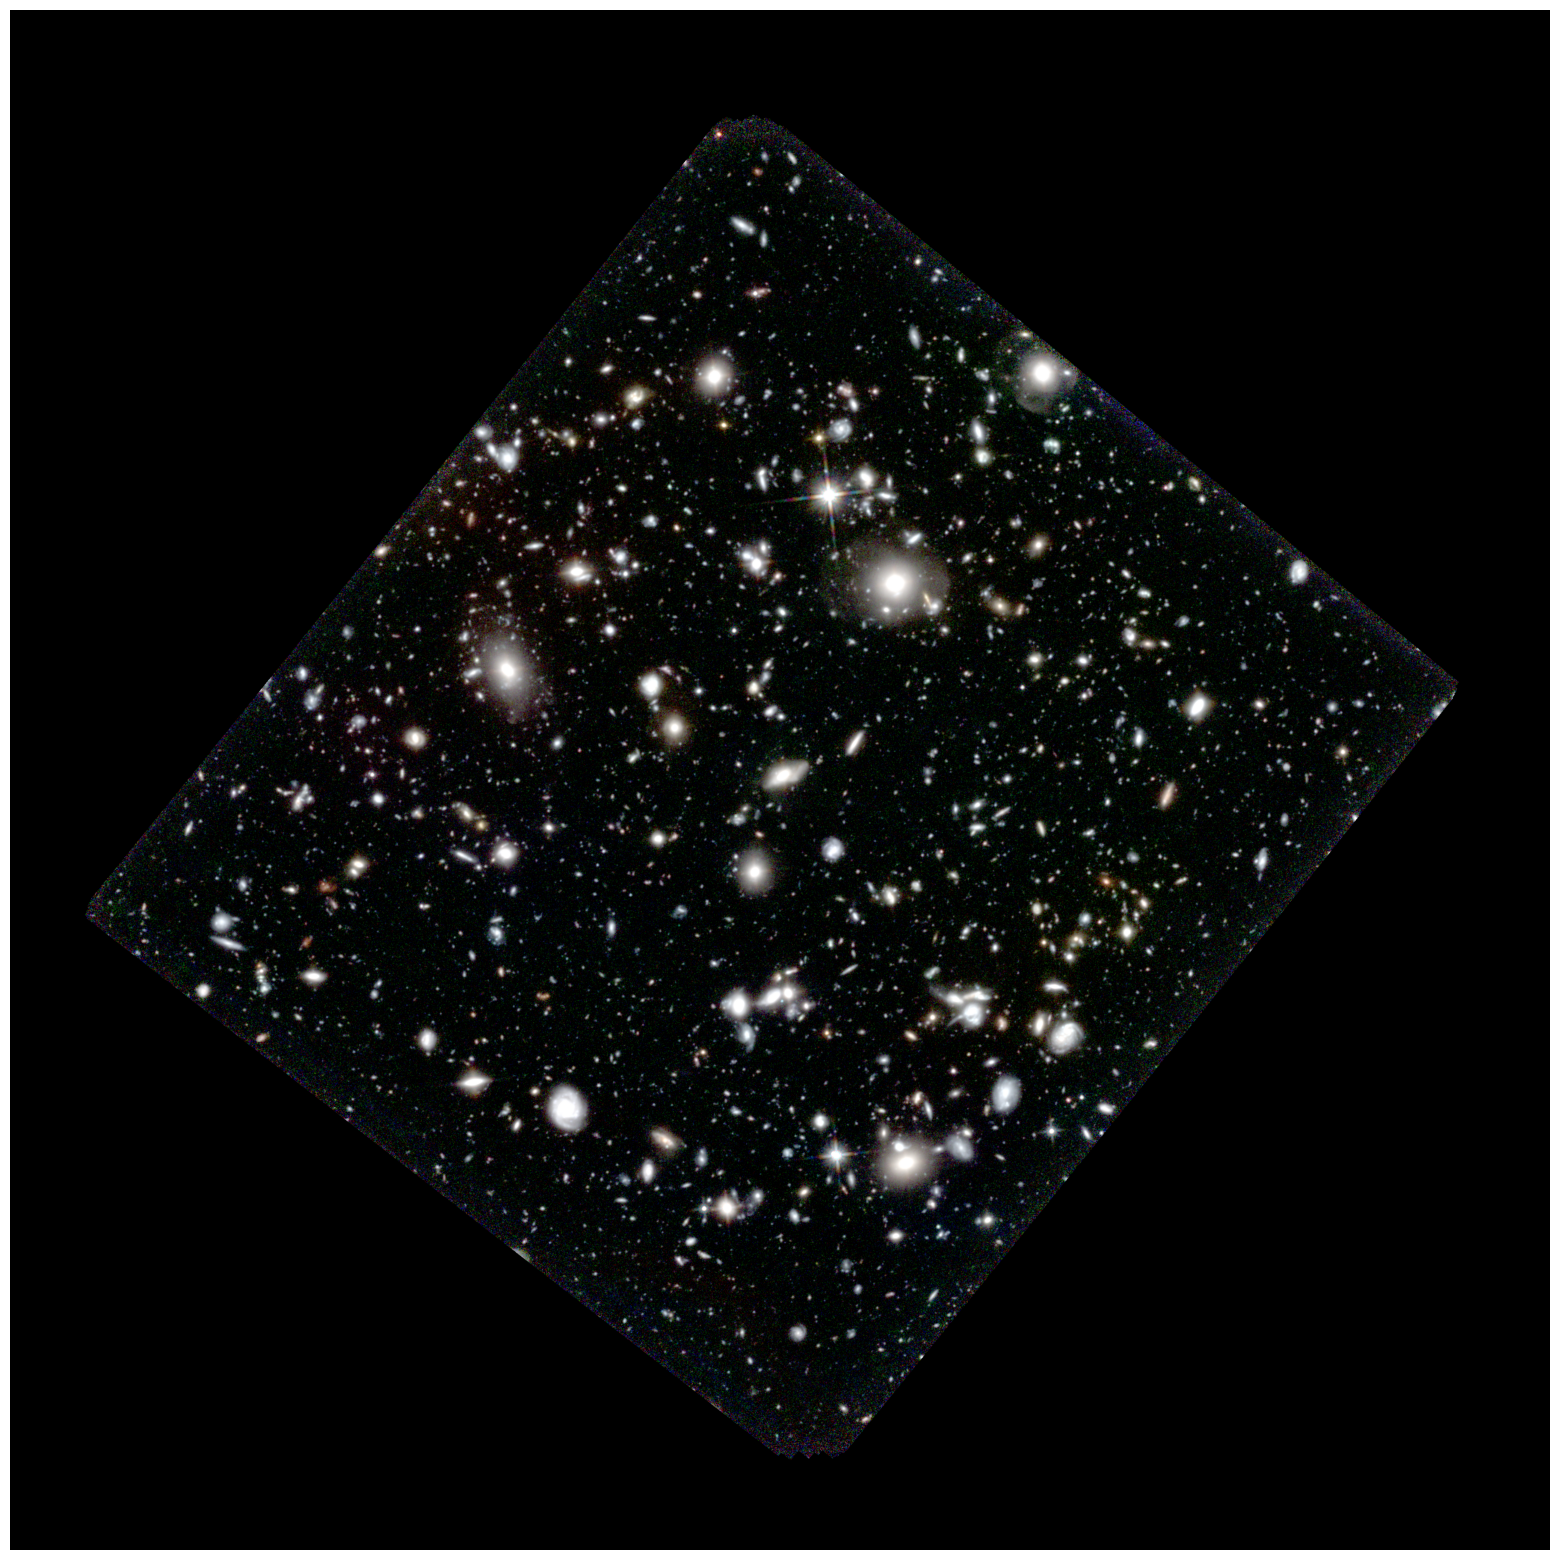

In [21]:
f,ax = plt.subplots(1,1,figsize=(20,20))
ax.axis('off')
ax.imshow(rgb)
plt.savefig('color-false-UDF.png', bbox_inches='tight', pad_inches=0,dpi=600)